# Opening large CZI files with AICSImageIO

When working with large microscopy images (e.g. multiple GB to TB per file), the data may exceed your memory capacity, potentially causing the kernel to crash. 
In this notebook, we will use the `AICSImageIO` library integrated with `Dask` to handle large `.czi` files efficiently.

⚠️ <u>Note</u>: [`AICSImageIO`](https://github.com/AllenCellModeling/aicsimageio) is no longer actively maintained. If you run into issues while following this notebook, please try its compatible successor [`BioIO`](https://bioio-devs.github.io/bioio/OVERVIEW.html).



## Requirements

Before getting started, ensure that you have the necessary libraries for handling bioimage formats and `.czi` files installed. If not, please run these two commands in your command line:

    pip install aicsimageio  
    pip install aicspylibczi 

## Reading large CZI files

We will use the mouse brain image `Demo_LISH.czi` from [Nicolas Chiaruttini](https://zenodo.org/records/8305531)
  licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode). To execute the notebook yourself, download the required data file "[Demo LISH 4x8 15pct 647.czi](https://zenodo.org/records/8305531)" and change the file path accordingly.

  First, we will load the image using the `AICSImage` class - just as we would with smaller files. 


In [1]:
from aicsimageio import AICSImage

In [2]:
# Change the path below to your own file path
image = AICSImage("../../../../DEMO/Demo_LISH.czi") 

Next, we will make use of `Dask` (a parallel computing library for big data analytics) to inspect the size and structure of the image. At this stage, no actual image data is loaded into memory yet - only metadata. This approach allows you to:
- Get an overview of the data
- Select specific parts of the data you would like to work with (e.g. specific channel, time point, z-plane, cropped region, etc.) 
- Downsample (i.e. use only every nth pixel of the image) 

In [3]:
image.xarray_dask_data

<xarray.DataArray 'transpose-506280ba1d783e556f9f1a891403c814' (T: 1, C: 1,
                                                                Z: 56, Y: 6254,
                                                                X: 4969)> Size: 3GB
dask.array<transpose, shape=(1, 1, 56, 6254, 4969), dtype=uint16, chunksize=(1, 1, 56, 1094, 1094), chunktype=numpy.ndarray>
Coordinates:
  * C        (C) <U4 16B 'Cam2'
  * Z        (Z) float64 448B 0.0 100.0 200.0 300.0 ... 5.3e+03 5.4e+03 5.5e+03
  * Y        (Y) float64 50kB 0.0 1.874 3.747 ... 1.171e+04 1.171e+04 1.172e+04
  * X        (X) float64 40kB 0.0 1.874 3.747 ... 9.304e+03 9.306e+03 9.308e+03
Dimensions without coordinates: T
Attributes:
    unprocessed:  <Element 'ImageDocument' at 0x7b5db34efc40>

In this example, we will extract every 5th pixel along each dimensional axis of the image in order to save memory and processing time for subsequent analysis.

In [4]:
image_reduced = image.get_image_dask_data(
    "CZYX", 
    T = 0,
    X = slice(0, -1, 5), 
    Y = slice(0, -1, 5), 
    Z = slice(0, -1, 5))

Now, we will call `.compute` to load the selected part of data into memory. 

In [5]:
brain_image = image_reduced.compute()

⚠️ <u>Note</u>: The last command is moving data into memory. It will likely run a little longer. 

In case you experience a kernel crash, try the following options: 
- Further reduce your data (e.g. select every 50th pixel instead of every 5th pixel, select only one z-plane, etc.)
- Free up memory (see the [last section of this notebook](#Freeing-up-memory)).


## Visualizing

Let's display our image with `stackview`. You can also use `napari` if you prefer a more interactive viewer, as shown [here](https://github.com/haesleinhuepf/BioImageAnalysisNotebooks/tree/main/docs/16_3d_image_visualization).

In [6]:
import stackview 

StackViewNDArray([[[[263, 236, 253, ..., 217, 232, 248],
                    [236, 254, 240, ..., 238, 239, 246],
                    [231, 256, 262, ..., 247, 254, 237],
                    ...,
                    [216, 204, 212, ..., 216, 210, 217],
                    [230, 216, 222, ..., 192, 208, 207],
                    [219, 204, 212, ..., 216, 206, 205]],

                   [[259, 243, 252, ..., 250, 235, 221],
                    [226, 255, 263, ..., 238, 229, 235],
                    [248, 280, 272, ..., 259, 263, 234],
                    ...,
                    [222, 208, 218, ..., 217, 207, 212],
                    [241, 212, 221, ..., 193, 202, 215],
                    [228, 224, 224, ..., 204, 219, 203]],

                   [[251, 259, 273, ..., 268, 248, 248],
                    [266, 252, 274, ..., 272, 280, 240],
                    [248, 271, 261, ..., 267, 240, 238],
                    ...,
                    [247, 233, 230, ..., 227, 207, 215],
                    [254, 262, 248, ..., 195, 214, 218],
                    [259, 245, 237, ..., 213, 199, 212]],

                   ...,

                   [[236, 232, 227, ..., 220, 213, 220],
                    [240, 251, 241, ..., 233, 214, 228],
                    [239, 264, 242, ..., 213, 224, 212],
                    ...,
                    [239, 249, 251, ..., 247, 216, 228],
                    [274, 259, 253, ..., 215, 216, 222],
                    [245, 249, 279, ..., 228, 222, 223]],

                   [[212, 209, 209, ..., 214, 207, 213],
                    [209, 212, 223, ..., 211, 220, 201],
                    [203, 229, 225, ..., 213, 211, 209],
                    ...,
                    [210, 221, 212, ..., 223, 218, 233],
                    [217, 219, 215, ..., 207, 226, 210],
                    [227, 214, 219, ..., 219, 218, 216]],

                   [[213, 211, 202, ..., 209, 213, 203],
                    [206, 207, 206, ..., 215, 219, 201],
                    [205, 219, 218, ..., 214, 208, 213],
                    ...,
                    [207, 207, 215, ..., 213, 202, 209],
                    [213, 205, 209, ..., 186, 206, 206],
                    [217, 216, 218, ..., 206, 192, 203]]]], dtype=uint16)
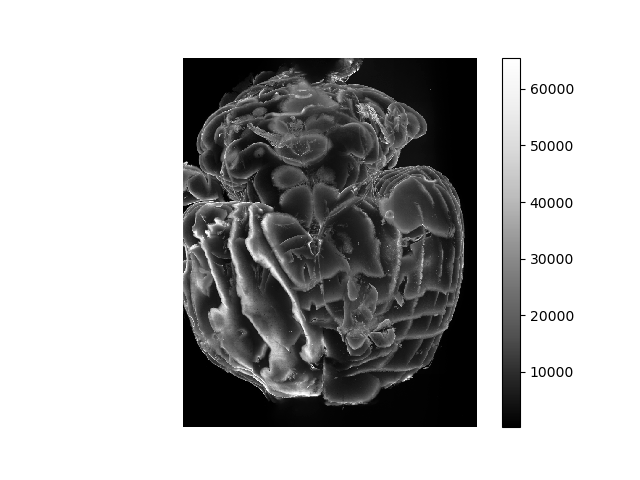
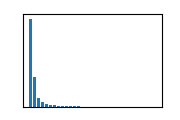

In [7]:
stackview.insight(brain_image)

## Freeing up memory

Before adding (new) data into memory, it can be helpful to free up space by deleting variables you are no longer using with `del`. You can also use Python's built-in garbage collector `gc` to manually force a cleanup of unreachable objects. This reduces the risk of memory overload. 

⚠️ <u>Note</u>: Be cautious when deleting variables - once deleted, you will need to re-run the earlier code to generate them again.

In [8]:
del brain_image

In [9]:
import gc
gc.collect()

8908